# Restricted Boltzmann Machine
---
**Copyright (c) 2018 Kristopher McBrian**

Train a Restricted Boltzmann Machine to represent the probability distribution of the 2D Ising Model

In [63]:
import numpy as np
import matplotlib.pyplot as plt

#Training Parameters -----------------------
data_set_size = 10000
batch_size = 20
num_batches = int(data_set_size/batch_size)
num_epochs = 5
learning_rate = 0.2
k = 5

# System Parameters
T = 1.0

## RBM System Parameters
---
Initializing the number of rows and columns for the visible and hidden layer

In [64]:
# Visible layer structure
n_v_r = 1 # rows
n_v_c = 6 # columns
N_v = n_v_r * n_v_c # Total number of visible nodes

#Hidden Layer structure
n_h_r = 3
n_h_c = 3
N_h = n_h_r * n_h_c

** RBM Paramter Arrays**
- W: holds weight values for every possible pair of visible and hidden nodes.  It initial values are sampled from a uniform distribution in the range $[\frac{-1}{2(N_v + N_h)},\frac{1}{2(N_v + N_h)}]$.
- v_bias: The bias for a particular visible node to have a value of 1
- h_bias: The bias for a particular hidden node to have a value of 1

In [65]:
# Array Initialization ----------------------
width = np.sqrt(1./(N_v + N_h)) 
W = np.random.uniform(low=-width/2., high=width/2., size=(N_v*N_h)).reshape((n_v_r, n_v_c, n_h_r, n_h_c))
v_bias = np.ones(N_v).reshape(n_v_r, n_v_c)
h_bias = np.ones(N_h).reshape(n_h_r, n_h_c)

## Obtaining the Training Set for the Restricted Boltzmann Machine
---
**Ising Model Hamiltonian**
$$ H = \sum_{<i,j>}\sigma_i \sigma_j$$
The ising model hamiltonian is given by the function above
where $<i,j>$ means the nearest neighbors on the lattice

In [66]:
def H(spin):
    
    n_r, n_c  = spin.shape # used for for loops
    spin = 2 * spin - 1 # maps {0,1} to {-1,1}
    
    H = 0.
    for i in range(n_r):
        for j in range(n_c):
            if j+1 != n_c: #if next index is not out of bounds
                H += spin[i,j]*spin[i,j+1]
            if i+1 != n_r:
                H += spin[i,j]*spin[i+1,j]
    return -H

** Metropolis-Hastings Algorithm**

This is a Monte Carlo algorithm that chooses one spin site on the lattice to flip the spin.  The flip is automatically accepted if the energy of the system decreases due to the flip, but will flip with some probability from a Boltzmann distribution if the energy of the system increases dependent on the temperature and change in energy of the system. 

In [67]:
def Met_Hast(n_v_r,n_v_c, T, num_iterations):
        #Random spin configuration
        spin = 2* np.random.randint(2,size = (n_v_r,n_v_c)) - 1 #{0,1} --> {-1,1}
        E = H(spin) # calculate initial energy
        data_set = np.zeros((num_iterations, n_v_r,n_v_c),dtype=int)
        
        for i in range(num_iterations):
            #Choose random coordinate on 2d lattice to flip
            x = np.random.randint(n_v_r)
            y = np.random.randint(n_v_c)
            spin[x,y] *= -1
            
            #Calculate energy change due to flipped spin
            E_neighbors = 0.
            if x != 0:         # if there is a site to the left
                E_neighbors += spin[x-1,y]
            if x != (n_v_r-1): # if there is a site to the right
                E_neighbors += spin[x+1,y]
            if y != 0:         # if there is a site below
                E_neighbors += spin[x,y-1]
            if y != (n_v_c-1): # if there is a site above
                E_neighbors += spin[x,y+1]

            dE = -2 * spin[x,y] * E_neighbors

            #Accept or reject the flipped site
            if np.random.random() < np.exp(-dE/T):
                E += dE
            else:
                spin[x,y] *= -1

            #Add spin configuration to data set
            np.copyto(data_set[i,:,:], spin)
        return (data_set+1)/2 #{-1,1} --> {0,1}

Getting the training set for the RBM and shuffling to randomize the order of the data

In [68]:
data_set = Met_Hast(n_v_r, n_v_c, T, data_set_size)
np.random.shuffle(data_set)

**Calculating the probability distribution represented by the RBM**

A probability distribution can be represented by the parameter values of the Restricted Boltzmann Machine based on the formula
$$ p(\pmb\sigma) = \frac{1}{Z}e^{\varepsilon} $$
where $\varepsilon$ is defined as
$$ \varepsilon = \sum_{j}b_j \sigma_j + \sum_{i} log(1+e^{c_i + \sum W_{ij} \sigma_j})$$

- $\sigma_j$: jth visible node
- $b_j$: bias of jth visible node
- $c_i$: bias of ith hidden node
- $W_{ij}$: weight between ith hidden node and jth visible node
- $Z$: Partition Function

In [69]:
def p_model(W, v_bias, h_bias, v_set):
    n_spin = len(v_set[0,0,:])
    n_v_r,n_v_c = v_bias.shape
    n_h_r,n_h_c = h_bias.shape
    p_model = np.zeros(n_spin)

    for spin in range(n_spin):
        c_ = 0.
        a_ = np.sum(v_bias*v_set[:,:,spin])
        for i in range(n_h_r):
            for j in range(n_h_c):
                b_ = np.sum(np.multiply(W[:,:,i,j], v_set[:,:,spin]))
                c_ += np.log(1 + np.exp(h_bias[i,j] + b_))
        p_model[spin] = np.exp(a_ + c_)
    Z = float(np.sum(p_model))
    return p_model/Z

def p_s(size, T):
    #size: tuple - (n_r, n_c)
    #Used in exact Hamiltonian models
    #   -calculate e^-(H(sig)/T) /Z
    N = size[0]*size[1]
    p_model = np.zeros(2**N)
    v_set = np.zeros((size[0],size[1],2**N)) #set of all possible spin configurations
    for i in range(len(p_model)):

        np.copyto(v_set[:,:,i], np.array([int(x) for x in np.binary_repr(i,width=N)]).reshape(size))
        p_model[i] = np.exp(-H(v_set[:,:,i])/T)
    Z = np.sum(p_model)
    return p_model/Z, v_set


p_exact,v_set = p_s((n_v_r, n_v_c), T)
p_model_before_train = p_model(W, v_bias, h_bias, v_set)

# Gibb's Sampling
Called in the Training Function

- Calculate the probability that each hidden node has a value of 1. Probability is dependent on visible layer.  This probability is sampled against the binomial distribution 
- Calculate the probability that each visible node has a value of 1. Probability is dependent on hidden layer.  This probability is sampled against the binomial distribution 
- Repeat k times

In [70]:
def gibbs_sampling(k, v_0, W, v_bias, h_bias):
    v_k = np.zeros_like(v_0)
    h_0 = np.zeros_like(h_bias)
    h_k = np.zeros_like(h_bias)

    h_0 = gibbs_vtoh(W, v_0, h_bias)
    v_k = gibbs_htov(W, h_0, v_bias)
    for i in range(k):
        h_k = gibbs_vtoh(W, v_k, h_bias)
        v_k = gibbs_htov(W, h_k, v_bias)
    return v_k, h_0, h_k


def gibbs_vtoh(W, v, h_bias):
    activation=np.zeros_like(h_bias)
    for i in range(activation.shape[0]):
        for j in range(activation.shape[1]):
            activation[i,j] = sigmoid(h_bias[i,j] + np.sum(v*W[:,:,i,j]))

    h_k = np.random.binomial(1,activation,size=activation.shape)
    return h_k

def gibbs_htov(W, h, v_bias):
    activation=np.zeros_like(v_bias)
    for i in range(activation.shape[0]):
        for j in range(activation.shape[1]):
            activation[i,j] = sigmoid(v_bias[i,j] + np.sum(h*W[i,j,:,:]))

    v_k = np.random.binomial(1, activation, size=activation.shape)
    return v_k

# Training using Stochastic Gradient Descent
- Update parameter based on derivative of Kullback-Leibler Divergence
- Minimize the KL-Divergence

In [71]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def train(W, v_bias, h_bias, k, data_set, batch_size, num_batches, num_epochs, learning_rate):
    #Gradient Descent Arrays
    dW = np.zeros_like(W)
    dv_bias = np.zeros_like(v_bias)
    dh_bias = np.zeros_like(h_bias)

    #Gibbs Sampling Arrays
    v_0 = np.empty_like(v_bias, dtype=int)
    v_k = np.empty_like(v_bias, dtype=int)
    h_0 = np.empty_like(h_bias, dtype=int)
    h_k = np.empty_like(h_bias, dtype=int)

    num_data = data_set.shape[0]
    start = np.random.randint(num_data)

    for i_epoch in range(num_epochs):
        for i_batches in range(num_batches):
            dW *= 0.
            dv_bias *= 0.
            dh_bias *= 0.
            for i_input in range(batch_size):
                # gibbs sample
                v_0 = data_set[(i_input + start + batch_size*i_batches) % num_data,:,:]
                v_k, h_0, h_k = gibbs_sampling(k, v_0, W, v_bias, h_bias)

                # update dW, dv_bias, ...
                dW += np.tensordot(v_0, h_0,axes=0) - np.tensordot(v_k, h_k,axes=0)
                dv_bias += v_0 - v_k
                dh_bias += h_0 - h_k
            
            # Update parameters 
            np.copyto(W, W + dW * learning_rate/batch_size)
            np.copyto(v_bias, v_bias + dv_bias * learning_rate/batch_size)
            np.copyto(h_bias, h_bias + dh_bias * learning_rate/batch_size)
            
            if (i_batches+1) % 100 == 0:
                print("Epoch: %d/%d"%(i_epoch+1, num_epochs), ' Batch: %d/%d'%(i_batches+1, num_batches))
    
    return W, v_bias, h_bias

Call the training algorithm and then construct the probability distribution of each spin configuration based on the weights and biases in the RBM.  

In [72]:
# Train
W, v_bias, h_bias = train(W, v_bias, h_bias, k, data_set, batch_size, num_batches, num_epochs, learning_rate)

# Find Probability distribution of states
p_model_after_train = p_model(W, v_bias, h_bias, v_set)

Epoch: 1/5  Batch: 100/500
Epoch: 1/5  Batch: 200/500
Epoch: 1/5  Batch: 300/500
Epoch: 1/5  Batch: 400/500
Epoch: 1/5  Batch: 500/500
Epoch: 2/5  Batch: 100/500
Epoch: 2/5  Batch: 200/500
Epoch: 2/5  Batch: 300/500
Epoch: 2/5  Batch: 400/500
Epoch: 2/5  Batch: 500/500
Epoch: 3/5  Batch: 100/500
Epoch: 3/5  Batch: 200/500
Epoch: 3/5  Batch: 300/500
Epoch: 3/5  Batch: 400/500
Epoch: 3/5  Batch: 500/500
Epoch: 4/5  Batch: 100/500
Epoch: 4/5  Batch: 200/500
Epoch: 4/5  Batch: 300/500
Epoch: 4/5  Batch: 400/500
Epoch: 4/5  Batch: 500/500
Epoch: 5/5  Batch: 100/500
Epoch: 5/5  Batch: 200/500
Epoch: 5/5  Batch: 300/500
Epoch: 5/5  Batch: 400/500
Epoch: 5/5  Batch: 500/500


In [73]:
def KL_div(exact, model):
    A = 0.
    for i in range(len(exact)):
        A +=  exact[i] * np.log(exact[i]/model[i])
    return A

KL Divergence
Before Training: 2.3040911227019083
After Training: 0.03734101464857721


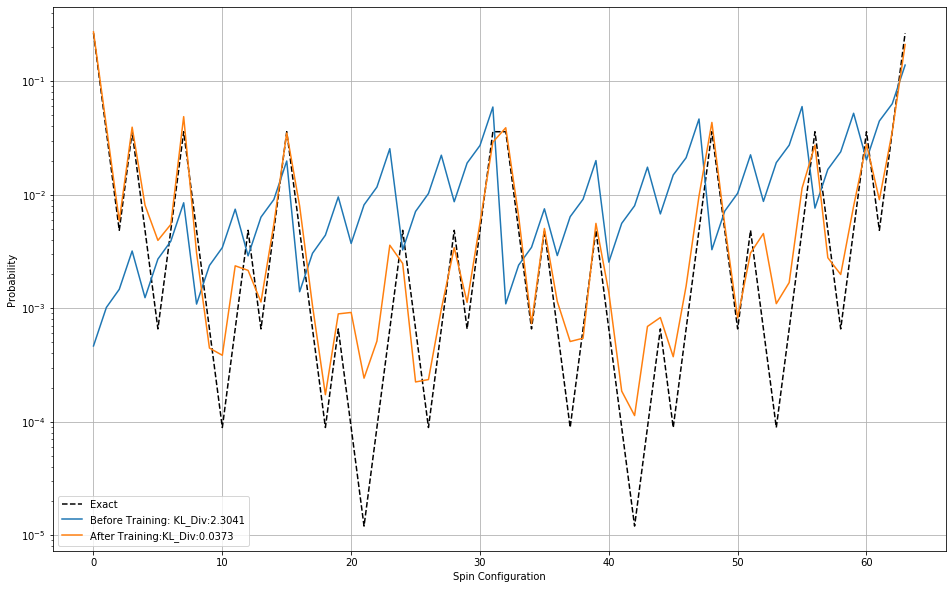

In [74]:
#Calculate the Kullback-Leibler Divergence
KL_b = KL_div(p_exact, p_model_before_train)
KL_a = KL_div(p_exact, p_model_after_train)

print('KL Divergence')
print('Before Training:', KL_b)
print('After Training:', KL_a)

#Plot the probability distributions
plt.figure(figsize=(16, 10))

plt.plot(p_exact, 'k--',label='Exact')
plt.plot(p_model_before_train, label='Before Training: KL_Div:%.4f'%KL_b)
plt.plot(p_model_after_train, label='After Training:KL_Div:%.4f'%KL_a)

plt.yscale('log')
plt.ylabel("Probability")
plt.xlabel("Spin Configuration")
plt.grid(True)
plt.legend(loc='best')
plt.show()

<h3>Sources</h3>
<blockquote>
    <p>Torlai, Giacomo, and Roger G. Melko. "Learning thermodynamics with Boltzmann machines." Physical Review B 94.16 (2016): 165134.</p>
    <p>Hinton, Geoffrey E. "Training products of experts by minimizing contrastive divergence." Neural computation 14.8 (2002): 1771-1800.</p>
    <p>Morningstar, Alan, and Roger G. Melko. "Deep learning the Ising model near criticality." arXiv preprint arXiv:1708.04622 (2017).</p>
</blockquote>